## Surface Interpolation

This notebook walks through the different steps needed to obtain the surface-interpolated precipitation values over each individual catchment. 

In [1]:
import paths
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.dates as mdt
import matplotlib.ticker as mtk

from tqdm import tqdm
from train_model import load_data
from preprocessing import visualisation
from preprocessing import surface_interpolation as si
from preprocessing import catchment_characteristics as cc

### 1. Input Parameters

Define the number (gauge station) of the catchment we want to interpolate over. Based on this catchment number we retrieve the catchment boundary (as a shapefile), from the larger 'Catchment_Fens.csv'. This csv-file is constructed based on the information available from the NRFA website.

Additionally, we open the dataset containing the rainfall information over the UK (9h till 9h per day) from 1979 till 2021. 

Lastly, we define the grid resolution at which the data will be interpolated (integrated). 

In [53]:
station_nr = 54057

database = pd.read_csv('../' + paths.DATA + '/Catchments_Database.csv').rename(columns={'Station number': 'Station_number'})

station_db = database.query(f"Station_number == {station_nr}")
catchment_boundary = gpd.read_file('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '.shp'))

domain_rain = xr.open_dataset('../' + paths.RAINFALL_UK_SHIFTED)
                              
DATA_RESOLUTION = 0.25
INTEGRATION_RESOLUTION = 0.05

### 2. Raster Extraction

We extract the raster over which we will fit the interpolation curves (to avoid fitting curves over the full territory of the UK). We can visualize this raster on a map of the UK, displaying the precipitation intensity per grid square for a specific day (here by default 1st of January 1981).

In [67]:
bbox = si.extract_raster_to_interpolate(catchment_boundary, DATA_RESOLUTION)
visualisation.plot_spatial_distribution(domain_data=domain_rain, 
                                        catchment_polygon=catchment_boundary, 
                                        date=(1981,1,1), 
                                        value_column='tp', 
                                        bbox=bbox, 
                                        crop=True)

### 3. Grid Interpolation

Based on the cropped grid, we fit a set of functions to the data (1 for each timestep, corresponding to 1 day, in the dataset). Visualization of the first few functions shows how the precipitation intensity varies over time.

100%|██████████| 15706/15706 [03:12<00:00, 81.69it/s] 


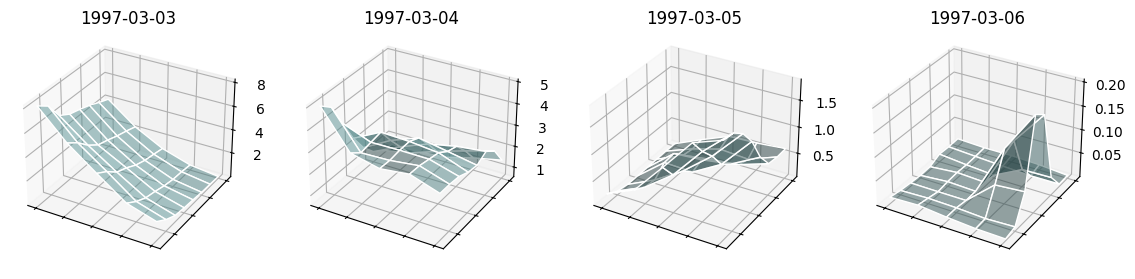

CPU times: total: 1min 21s
Wall time: 3min 12s


In [52]:
%%time
    
lat_min, lat_max, lon_min, lon_max = si.extract_raster_to_interpolate(catchment_boundary, DATA_RESOLUTION)
subset = domain_rain.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

save_path = f"{paths.IMAGES}/interpolation_precipitation_{station_nr}.png"
interpolated_functions = si.interpolate_surface(subset, plot=True, save_path=save_path, plot_date='1997-03-03')

100%|██████████| 15706/15706 [03:10<00:00, 82.59it/s] 


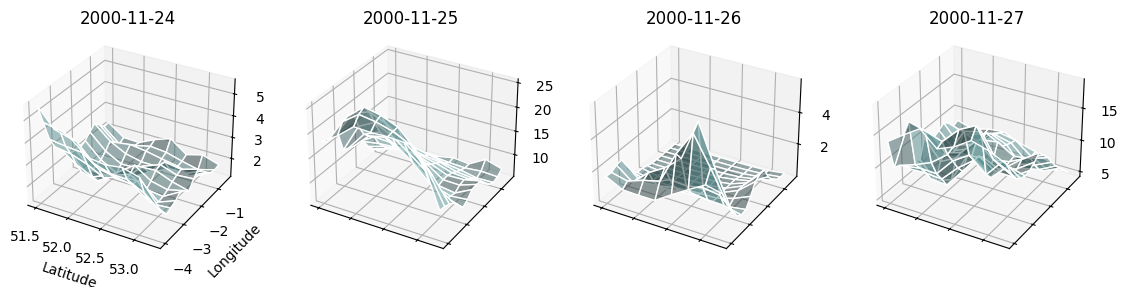

CPU times: total: 56.8 s
Wall time: 3min 11s


In [5]:
%%time
    
lat_min, lat_max, lon_min, lon_max = si.extract_raster_to_interpolate(catchment_boundary, DATA_RESOLUTION)
subset = domain_rain.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

save_path = f"{paths.IMAGES}/interpolation_precipitation.png"
interpolated_functions = si.interpolate_surface(subset, plot=True, save_path=save_path)

### 4. Integration over the Catchment Surface

The surface interpolation only applies to the precipitation and thus, for all other parameters, we recuperate the linearly interpolated values from before.

To integrate over a surface with an irregular shape, we define a grid of points (with a predefined resolution) around the catchment polygon. We evaluate the points that lie within the polygon through the previously defined interpolated functions, for each timestep. Dividing the sum of these values by the number of points within the polygon gives the final precipitation value for the catchment.

Additionally, we recalculate the shifted rain values (28 per day) and proxies (30, 60, 90 days rolling mean) from the newly obtained precipitation values. 

In [90]:
rain_columns = (['Rain'] + ['Rain-' + f'{d+1}' for d in range(27)])
rf_test = load_data.load_data('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_linear.csv'), verbose=False)
rf_test = rf_test.drop(columns=rain_columns)

In [7]:
%%time
tqdm.pandas()
rf_test = rf_test[:365]
rf_test['Rain'] = rf_test['Date'].progress_apply(
    lambda time: si.integrate_rainfall_over_polygon(catchment_boundary, interpolated_functions[np.datetime64(time, 'ns')], grid_resolution=0.05)
).astype('float64')
rf_test

100%|██████████| 365/365 [00:16<00:00, 21.75it/s]

CPU times: total: 8.69 s
Wall time: 16.8 s


,Unnamed: 0,Date,Flow,Temperature,U Windspeed,V Windspeed,Humidity,Snow Melt,Resultant Windspeed,Rain_28_Mu,...,Snow Melt-26,Snow Melt-27,Snow Melt_28_Mu,Snow Melt_90_Mu,Snow Melt_180_Mu,Soil Moisture 1,Soil Moisture 2,Soil Moisture 3,Soil Moisture 4,Rain
30,209,1979-07-29,24.610,289.192714,2.131624,0.346983,90.298403,0.000000e+00,2.159680,1.832114,...,0.000000e+00,0.000000e+00,0.000000e+00,0.162807,1.366499,0.257479,0.227100,0.186925,0.264751,7.021623
31,210,1979-07-30,13.310,289.282499,1.115163,2.701634,67.426046,0.000000e+00,2.922741,2.011232,...,0.000000e+00,0.000000e+00,0.000000e+00,0.161369,1.358995,0.253336,0.241340,0.187457,0.264386,5.103110
32,211,1979-07-31,31.400,286.365548,2.554423,-0.198144,83.679629,0.000000e+00,2.562097,2.165561,...,0.000000e+00,0.000000e+00,0.000000e+00,0.154775,1.358995,0.298898,0.252404,0.188421,0.264032,4.438989
33,212,1979-08-01,12.960,287.929844,1.677456,0.213912,68.266646,0.000000e+00,1.691040,2.234341,...,0.000000e+00,0.000000e+00,0.000000e+00,0.152169,1.357424,0.258805,0.255163,0.190588,0.263686,2.099411
34,213,1979-08-02,9.070,287.278838,0.887203,-2.407181,74.023196,0.000000e+00,2.565473,2.274194,...,0.000000e+00,0.000000e+00,0.000000e+00,0.147471,1.357424,0.254544,0.249585,0.191976,0.263332,1.665302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,569,1980-07-23,4.856,286.828825,1.227417,4.508767,85.568064,5.204170e-15,4.672851,3.934939,...,5.204170e-15,5.204170e-15,5.204170e-15,0.003065,0.595176,0.300658,0.283246,0.252768,0.250363,2.122936
391,570,1980-07-24,3.812,286.540125,2.304123,1.701959,58.689846,5.204170e-15,2.864550,3.914603,...,5.204170e-15,5.204170e-15,5.204170e-15,0.003065,0.595176,0.266312,0.276965,0.255145,0.250468,1.023666
392,571,1980-07-25,34.350,292.674418,-0.221589,5.403362,60.194688,5.204170e-15,5.407904,3.951842,...,5.204170e-15,5.204170e-15,5.204170e-15,0.003065,0.595176,0.255315,0.266053,0.255238,0.250561,2.757376
393,572,1980-07-26,54.820,293.134053,0.232582,0.933391,62.387712,5.204170e-15,0.961932,4.807182,...,5.204170e-15,5.204170e-15,5.204170e-15,0.003065,0.594253,0.267925,0.263159,0.255069,0.250672,26.020660


In [143]:
si.plot_integration(catchment_boundary, grid_resolution=0.05)

### 5. Define Integration Resolution

Calculation of integration over as well a 0.05 as a 0.01° degree resolution, to show that the error between both is very very small and thus, to reduce computing time, the 0.05 resolution will be used.

In [121]:
tqdm.pandas()

rf_0_05degree = rf_test.copy()
rf_0_05degree['Rain'] = rf_0_05degree['Date'].progress_apply(
    lambda time: si.integrate_rainfall_over_polygon(catchment_boundary, interpolated_functions[np.datetime64(time, 'ns')], grid_resolution=0.05)
).astype('float64')

 28%|██▊       | 4299/15368 [05:30<14:10, 13.01it/s]


KeyboardInterrupt: 

In [98]:
rf_0_01degree = rf_test[:365].copy()
rf_0_01degree['Rain'] = rf_0_01degree['Date'].progress_apply(
    lambda time: si.integrate_rainfall_over_polygon(catchment_boundary, interpolated_functions[np.datetime64(time, 'ns')], grid_resolution=0.01)
).astype('float64')

100%|██████████| 365/365 [00:33<00:00, 10.90it/s]


In [116]:
rf_comparison = rf_0_01degree[['Date', 'Rain']].merge(rf_0_05degree[['Date', 'Rain']], on='Date')
rf_comparison = rf_comparison.rename(columns={'Rain_x': '0.01', 'Rain_y': '0.05'})
rf_comparison['error']  = rf_comparison['0.01'] - rf_comparison['0.05']

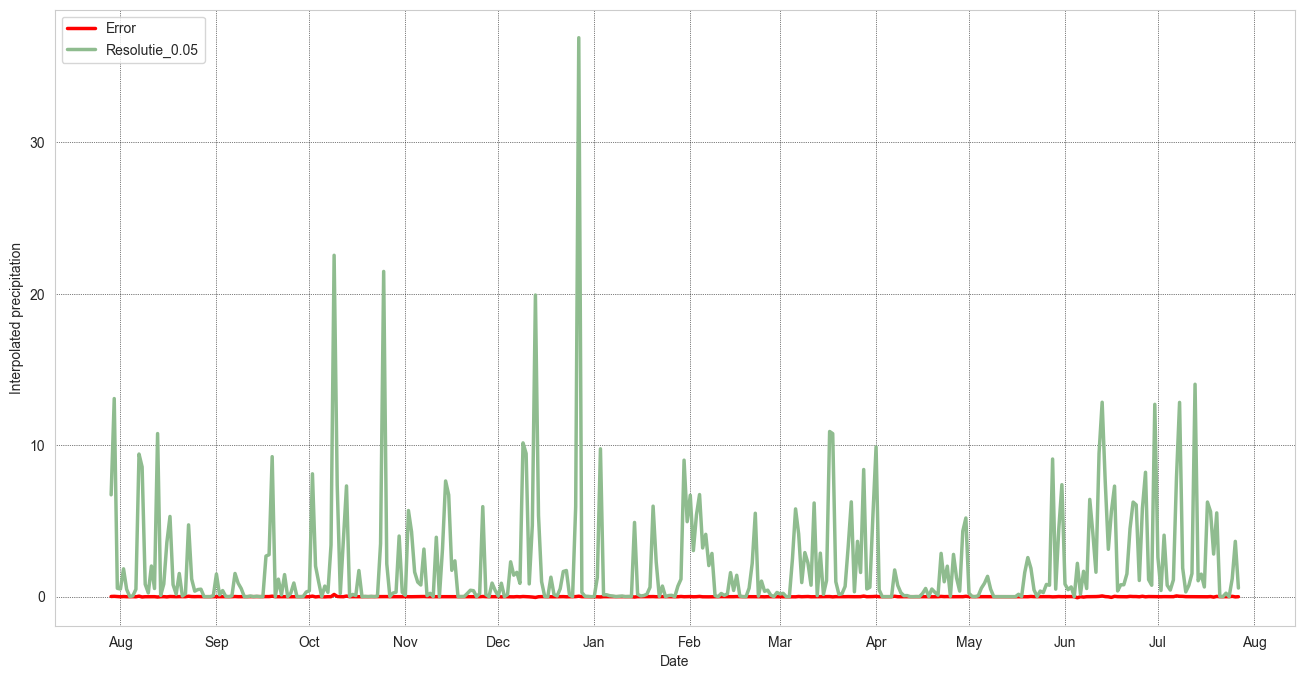

In [117]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(rf_comparison['Date'], rf_comparison['error'], 'red', lw=2.5)
ax.plot(rf_comparison['Date'], rf_comparison['0.05'], 'darkseagreen', lw=2.5)
ax.set_xlabel('Date')
ax.set_ylabel('Interpolated precipitation')

ax.xaxis.set_major_locator(mdt.MonthLocator())
ax.xaxis.set_major_formatter(mdt.DateFormatter('%b'))
ax.yaxis.set_major_locator(mtk.MaxNLocator(5))
ax.legend(['Error', 'Resolutie_0.05'], loc='upper left')
ax.grid(c='black', ls='dotted', lw=0.5)
plt.show()

### 5. Compare linear integration and surface interpolated integration

The following plot compares the precipitation values as obtained with the original (linear) interpolation method, and the precipitation values obtained with the new, surface interpolated method as described in this notebook.

In [69]:
importlib.reload(visualisation)

<module 'preprocessing.visualisation' from 'C:\\Users\\aline\\soil-moisture-proxies\\preprocessing\\visualisation.py'>

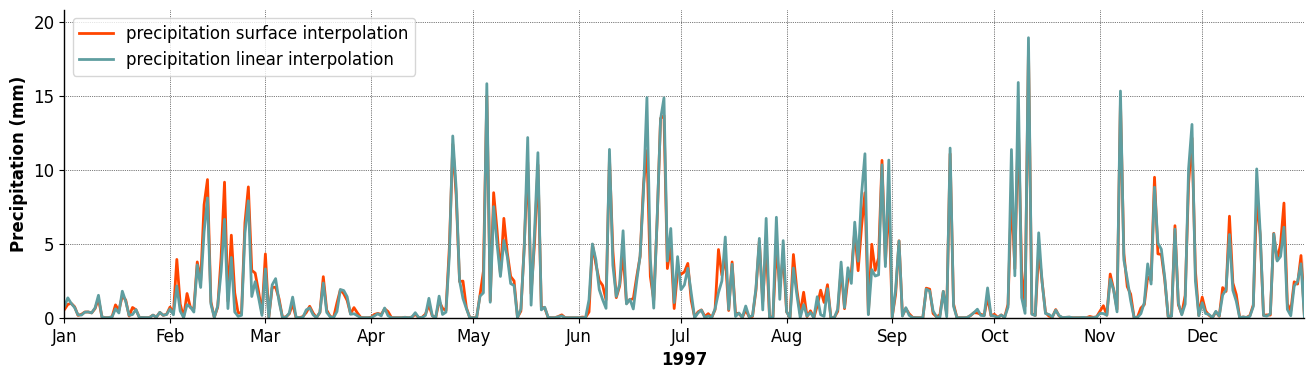

In [71]:
station_nr = 54057

rf_linear = load_data.load_data('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_linear.csv'), verbose=False)
rf_interp =load_data.load_data('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_surf_interp.csv'), verbose=False)

rf_linear['Date'] = pd.to_datetime(rf_linear['Date'], format='%Y-%m-%d')
rf_interp['Date'] = pd.to_datetime(rf_interp['Date'], format='%Y-%m-%d')

visualisation.compare_precipitation_and_flow(year = 1997,
                                             dfs_precipitation=[rf_interp, rf_linear], 
                                             colors=['orangered', 'cadetblue'],
                                             labels=['surface interpolation', 'linear interpolation'], 
                                             save_path=f"{paths.IMAGES}/comparison_interpolation_methods.png",
                                            figsize=(16,4))

### 6. Compare Model performance with surface interpolated values

The following plot compares the model performance with linearly interpolated precipitation values versus surface interpolated values (both including snow melt). 

In [162]:
overview_linear_snow_gdf = cc.get_characteristics_all_stations('../' + paths.CATCHMENT_BASINS, 
                                                   input_type='9to9_linear_Snow')
overview_surface_snow_gdf = cc.get_characteristics_all_stations('../' + paths.CATCHMENT_BASINS, 
                                                   input_type='9to9_surf_interp_Snow')

comparison = overview_linear_snow_gdf.merge(overview_surface_snow_gdf[['Station', 'NSE']], on='Station')
comparison = comparison.rename(columns={'NSE_x':'NSE_linear', 'NSE_y':'NSE_surface_interpolated'})

comparison['model_difference'] = comparison['NSE_linear'] - comparison['NSE_surface_interpolated']
#comparison[['Station', 'NSE_linear', 'NSE_surface_interpolated']]

C:\Users\aline\AppData\Local\Temp\ipykernel_4960\4262211919.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(latitude_labels, rotation=45)


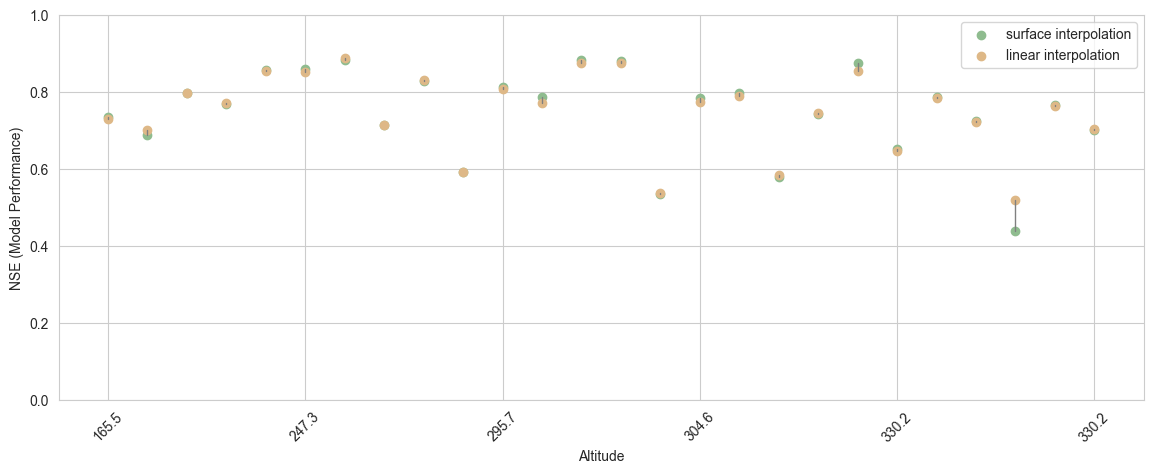

In [170]:
# Sort Dataframe by altitude
comparison = comparison.sort_values(by='Maximum altitude').reset_index(drop=True)
latitude_labels = [round(value, 2) for value in comparison['Maximum altitude']]

fig, ax1 = plt.subplots(figsize=(14, 5))

# Plot NSE values for Era5 and NRFA as dots
ax1.scatter(comparison.index, comparison['NSE_surface_interpolated'], color='darkseagreen', label='surface interpolation')
ax1.scatter(comparison.index, comparison['NSE_linear'], color='BurlyWood', label='linear interpolation')

# Draw lines between each pair of dots
for i in range(len(comparison)):
    ax1.plot([i, i], [comparison['NSE_linear'].iloc[i], comparison['NSE_surface_interpolated'].iloc[i]], color='gray', linestyle='-', linewidth=1)

# Labels and title for the first axis
ax1.set_xlabel('Altitude')
ax1.set_ylabel('NSE')
ax1.set_xticklabels(latitude_labels, rotation=45)
ax1.set_ylim(0,1)
ax1.set_ylabel('NSE (Model Performance)')
ax1.legend(loc='upper right')

plt.grid(True)
plt.savefig(f"{paths.IMAGES}/linear_vs_surface_modelperformance.png", dpi=300, bbox_inches='tight')
plt.show()